<a href="https://colab.research.google.com/github/NichBry25/BitcoinPricePrediction/blob/main/BTCForecasting_TCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ensures results are replicable

import os
os.environ["PYTHONHASHSEED"] = "42"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import random

In [3]:
# Ensures results are replicable

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [4]:
df = pd.read_csv('btc_forecasting_dataset3.csv')

In [5]:
df

,Date,btc_price,open,high,low,volume,spx_price,xau_price,vix_price,dxy_price,...,xau_logret_lag3,xau_logret_lag7,vix_logret_lag1,vix_logret_lag3,vix_logret_lag7,dxy_logret_lag1,dxy_logret_lag3,dxy_logret_lag7,btc_ma50,btc_ma200
0,2015-07-20,277.7,273.2,278.9,271.8,46600.0,2128.30,1096.95,12.25,98.03,...,-0.009696,-0.005134,0.000000,-0.013300,-0.191274,0.000000,0.001943,0.008606,252.782,246.4990
1,2015-07-21,275.1,277.7,281.0,274.2,49050.0,2119.20,1101.41,12.22,97.33,...,0.000000,-0.002135,0.024795,0.000000,-0.038875,0.001736,0.000000,-0.002274,253.822,246.2985
2,2015-07-22,276.5,275.1,277.4,273.1,41970.0,2114.20,1093.45,12.12,97.60,...,0.000000,-0.005102,-0.002452,0.000000,-0.010526,-0.007166,0.000000,0.005469,254.838,246.2455
3,2015-07-23,275.5,276.5,277.9,274.5,35660.0,2102.20,1090.80,12.64,97.11,...,-0.033306,-0.003922,-0.008217,0.024795,-0.088455,0.002770,0.001736,0.005132,255.836,246.2995
4,2015-07-24,288.4,275.5,289.8,274.3,74360.0,2079.70,1099.10,13.74,97.24,...,0.004058,-0.009696,0.042009,-0.002452,-0.013300,-0.005033,-0.007166,0.001943,257.120,246.3675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3752,2025-10-27,114108.0,114553.9,116307.5,113868.0,70790.0,6875.16,3981.59,15.79,98.78,...,-0.003416,0.024755,0.000000,-0.055256,-0.130922,0.000000,0.000101,0.001624,114272.866,108948.3695
3753,2025-10-28,112905.8,114110.3,116076.7,112266.9,52490.0,6890.89,3952.58,16.42,98.67,...,0.000000,-0.054579,-0.036074,0.000000,-0.019945,-0.001720,0.000000,0.003443,114289.614,109095.8330
3754,2025-10-29,110024.6,112904.7,113628.7,109506.4,66990.0,6890.59,3930.38,16.92,99.22,...,0.000000,-0.007551,0.039123,0.000000,0.040038,-0.001114,0.000000,-0.000303,114259.776,109219.4925
3755,2025-10-30,108320.1,110024.9,111585.8,106371.4,80070.0,6822.34,4024.47,16.91,99.53,...,-0.032253,0.007810,0.029996,-0.036074,-0.072455,0.005559,-0.001720,0.000404,114146.908,109342.4210


Anything beyond this section ending with "1" is representing the dataframe WITHOUT macro features. While "2" is representing WITH macro features.

In [22]:
TARGET = 'btc_logret'

In [7]:
FEATURES_1 = [
    'btc_price', 'open', 'high', 'low', 'volume',
    'btc_ma50', 'btc_ma200'
]

In [9]:
FEATURES_2 = [
    'btc_price','open','high','low','volume',
    'spx_price','xau_price', 'vix_price', 'dxy_price',
    'spx_logret','xau_logret', 'vix_logret', 'dxy_logret',
    'spx_logret_lag1','spx_logret_lag3','spx_logret_lag7',
    'xau_logret_lag1','xau_logret_lag3','xau_logret_lag7',
    'vix_logret_lag1','vix_logret_lag3','vix_logret_lag7',
    'dxy_logret_lag1','dxy_logret_lag3','dxy_logret_lag7',
    'btc_ma50','btc_ma200'
]

# Train - Val - Test Split

In [10]:
total_len = len(df)

In [11]:
train_end = int(total_len * 0.7)
val_end = int(total_len * 0.85)

train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

In [12]:
train_df.shape

(2629, 29)

In [13]:
val_df.shape

(564, 29)

In [14]:
test_df.shape

(564, 29)

# Scaling

In [15]:
scaler_1 = MinMaxScaler()

In [17]:
scaler_1.fit(train_df[FEATURES_1])

MinMaxScaler()

In [18]:
train_scaled_1 = scaler_1.transform(train_df[FEATURES_1])
val_scaled_1   = scaler_1.transform(val_df[FEATURES_1])
test_scaled_1  = scaler_1.transform(test_df[FEATURES_1])

In [16]:
scaler_2 = MinMaxScaler()

In [19]:
scaler_2.fit(train_df[FEATURES_2])

MinMaxScaler()

In [20]:
train_scaled_2 = scaler_2.transform(train_df[FEATURES_2])
val_scaled_2   = scaler_2.transform(val_df[FEATURES_2])
test_scaled_2  = scaler_2.transform(test_df[FEATURES_2])

In [23]:
y_train_full = train_df[TARGET].values
y_val_full   = val_df[TARGET].values
y_test_full  = test_df[TARGET].values

# Create Sequence Data

In [24]:
def make_sequence_data(values, target, lookback):
    X, y = [], []
    for i in range(lookback, len(values)):
        X.append(values[i - lookback:i])
        y.append(target[i])
    return np.array(X), np.array(y)

In [25]:
LOOKBACK = 60

In [28]:
X_train_1, y_train_1 = make_sequence_data(train_scaled_1, y_train_full, LOOKBACK)
X_val_1, y_val_1 = make_sequence_data(val_scaled_1, y_val_full, LOOKBACK)
X_test_1, y_test_1 = make_sequence_data(test_scaled_1, y_test_full, LOOKBACK)

In [27]:
X_train_2, y_train_2 = make_sequence_data(train_scaled_2, y_train_full, LOOKBACK)
X_val_2, y_val_2 = make_sequence_data(val_scaled_2, y_val_full, LOOKBACK)
X_test_2, y_test_2 = make_sequence_data(test_scaled_2, y_test_full, LOOKBACK)

# Modelling

In [30]:
def TCN_block(x, filters, kernel_size, dilation_rate):
  y = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate,
                    padding="causal", activation="relu")(x)
  y = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate,
                    padding="causal", activation="relu")(y)

  # Residual connection
  if x.shape[-1] != filters:
    x = layers.Conv1D(filters, 1, padding="same")(x)

  return layers.Add()([x, y])

In [32]:
def build_tcn(input_shape):
  inputs = layers.Input(shape=input_shape)

  x = TCN_block(inputs, filters=32, kernel_size=3, dilation_rate=1)
  x = TCN_block(x, filters=32, kernel_size=3, dilation_rate=2)
  x = TCN_block(x, filters=32, kernel_size=3, dilation_rate=4)

  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dense(32, activation="relu")(x)
  outputs = layers.Dense(1)(x)  # Predict 1 day log-return

  model = models.Model(inputs, outputs)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(1e-3),
      loss="mse"
  )
  return model

In [33]:
model_1 = build_tcn(X_train_1.shape[1:])

In [34]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60, 32)    │        704 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 60, 32)    │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 60, 32)    │      3,104 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 32)    │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 60, 32)    │      3,104 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 60, 32)    │      3,104 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 60, 32)    │          0 │ add[0][0],        │
│                     │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 60, 32)    │      3,104 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 60, 32)    │      3,104 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 60, 32)    │          0 │ add_1[0][0],      │
│                     │                   │            │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ add_2[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      1,056 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,569 (68.63 KB)

 Trainable params: 17,569 (68.63 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model_2 = build_tcn(X_train_2.shape[1:])

In [36]:
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 60, 27)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 60, 32)    │      2,624 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 60, 32)    │        896 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 60, 32)    │      3,104 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 60, 32)    │          0 │ conv1d_9[0][0],   │
│                     │                   │            │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 60, 32)    │      3,104 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 60, 32)    │      3,104 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 60, 32)    │          0 │ add_3[0][0],      │
│                     │                   │            │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 60, 32)    │      3,104 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 60, 32)    │      3,104 │ conv1d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 60, 32)    │          0 │ add_4[0][0],      │
│                     │                   │            │ conv1d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ add_5[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      1,056 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,129 (78.63 KB)

 Trainable params: 20,129 (78.63 KB)

 Non-trainable params: 0 (0.00 B)

# Training

In [37]:
EPOCHS = 50

In [38]:
BATCH_SIZE = 10

In [39]:
callback_early_stopping_1 = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

In [40]:
callback_early_stopping_2 = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

In [41]:
history_without_macro = model_1.fit(
    X_train_1, y_train_1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_1, y_val_1),
    callbacks=[callback_early_stopping_1],
    verbose=1
)

Epoch 1/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 3/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0019 - val_loss: 9.0708e-04
Epoch 4/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0018 - val_loss: 8.7023e-04
Epoch 5/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0018 - val_loss: 6.6110e-04
Epoch 6/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0018 - val_loss: 6.4352e-04
Epoch 7/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0017 - val_loss: 6.4221e-04
Epoch 8/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0017 - val_loss: 6.1753e-04
Epoch 9/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0017 - val_loss: 7.1902e-04
Epoch 10/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0017 - val_loss: 7.2816e-04
Epoch 11/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0017 - val_loss: 8.7365e-04
Epoch 12/50


In [42]:
history_with_macro = model_2.fit(
    X_train_2, y_train_2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_2, y_val_2),
    callbacks=[callback_early_stopping_2],
    verbose=1
)

Epoch 1/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0061 - val_loss: 0.0032
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0024 - val_loss: 9.8323e-04
Epoch 3/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0020 - val_loss: 6.5423e-04
Epoch 4/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 5/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 6/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 7/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 8/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0018 - val_loss: 6.5221e-04
Epoch 9/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0018 - val_loss: 6.7625e-04
Epoch 10/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0018 - val_loss: 7.7098e-04
Epoch 11/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0018 - val_loss: 7.7692e-04
Epoch 12/50
257/257 ━━

In [43]:
y_pred_1 = model_1.predict(X_test_1).ravel()
y_pred_2 = model_2.predict(X_test_2).ravel()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


# Metrics

In [44]:
def calculate_performance_metrics(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  da = np.mean((y_test * y_pred) > 0)
  return {"MSE": mse, "RMSE": rmse, "MAE": mae, "DA": da}

In [45]:
without_macro_metrics = calculate_performance_metrics(y_test_1, y_pred_1)

In [47]:
without_macro_metrics

{'MSE': 0.000585119611702773,
 'RMSE': np.float64(0.02418924578614995),
 'MAE': 0.01779894091910264,
 'DA': np.float64(0.5317460317460317)}

In [46]:
with_macro_metrics = calculate_performance_metrics(y_test_2, y_pred_2)

In [48]:
with_macro_metrics

{'MSE': 0.0006800495754543784,
 'RMSE': np.float64(0.026077760169431315),
 'MAE': 0.019703913915667476,
 'DA': np.float64(0.5178571428571429)}

# Price Reconstruction

In [49]:
actual_prices = test_df["btc_price"].iloc[LOOKBACK:].values

In [50]:
prev_actual_prices = test_df["btc_price"].iloc[LOOKBACK-1:-1].values

In [51]:
prev_actual_prices = prev_actual_prices[:len(y_pred_1)]

In [52]:
pred_price_1 = prev_actual_prices * np.exp(y_pred_1[:len(prev_actual_prices)])
pred_price_2 = prev_actual_prices * np.exp(y_pred_2[:len(prev_actual_prices)])

In [53]:
actual_prices = actual_prices[:len(pred_price_1)]

# Plotting

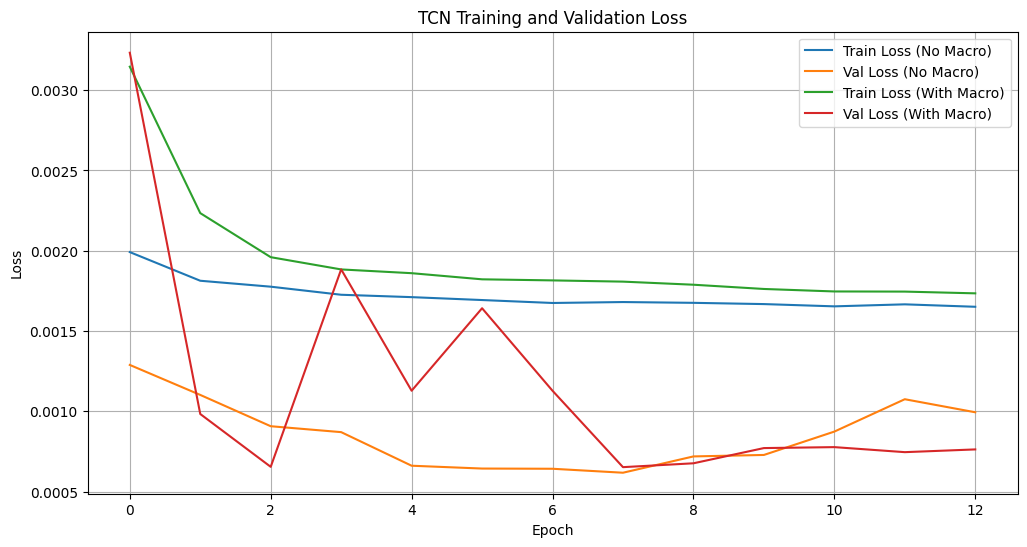

In [54]:
plt.figure(figsize=(12,6))
plt.plot(history_without_macro.history["loss"],     label="Train Loss (No Macro)")
plt.plot(history_without_macro.history["val_loss"], label="Val Loss (No Macro)")
plt.plot(history_with_macro.history["loss"],        label="Train Loss (With Macro)")
plt.plot(history_with_macro.history["val_loss"],    label="Val Loss (With Macro)")
plt.title("TCN Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

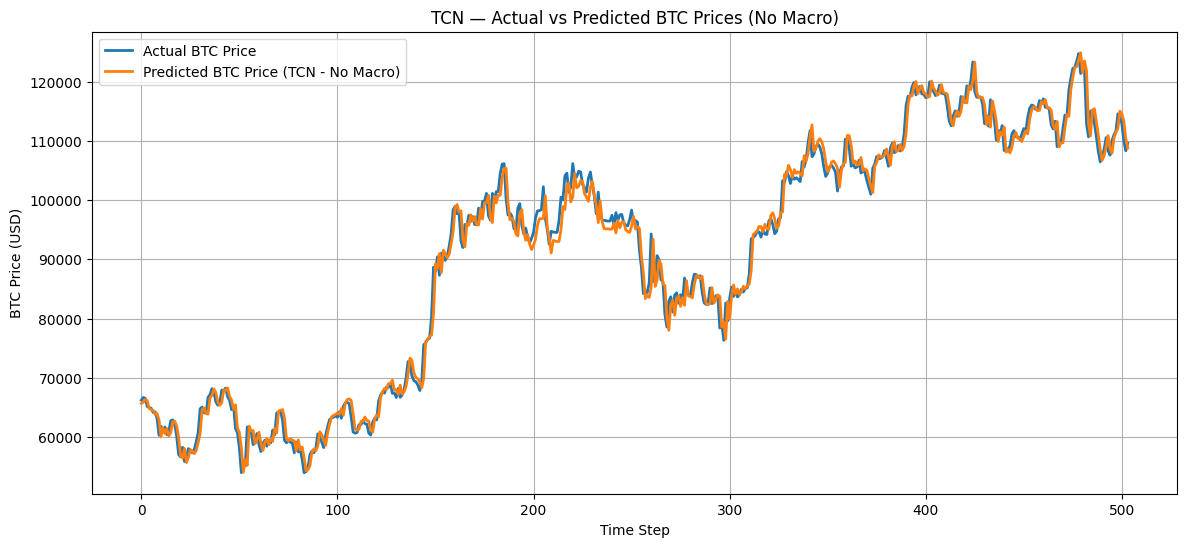

In [56]:
plt.figure(figsize=(14,6))
plt.plot(actual_prices, label="Actual BTC Price", linewidth=2)
plt.plot(pred_price_1, label="Predicted BTC Price (TCN - No Macro)", linewidth=2)
plt.title("TCN — Actual vs Predicted BTC Prices (No Macro)")
plt.xlabel("Time Step")
plt.ylabel("BTC Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

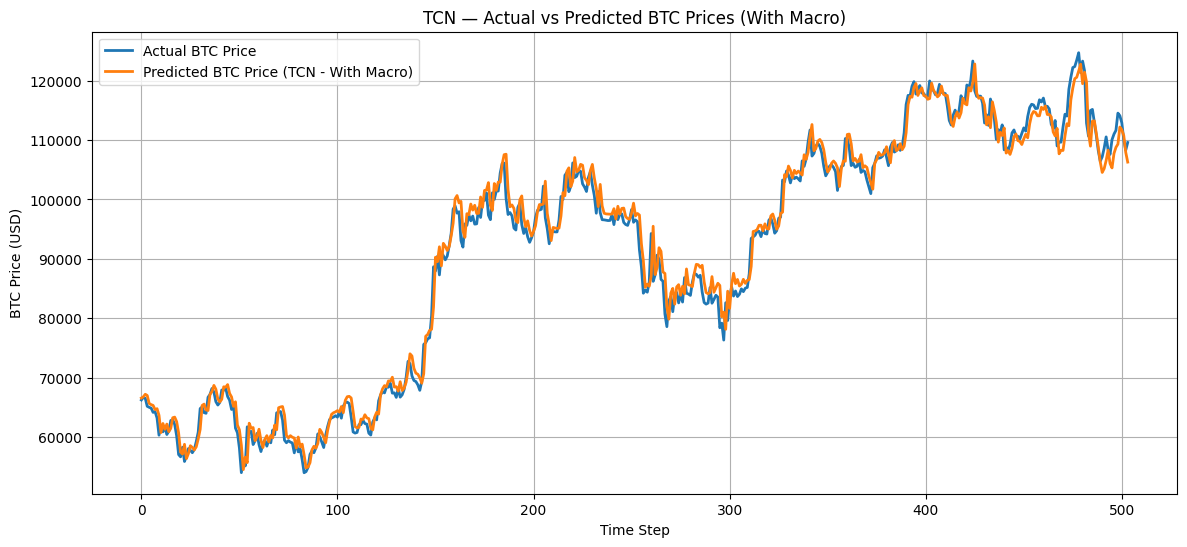

In [58]:
plt.figure(figsize=(14,6))
plt.plot(actual_prices, label="Actual BTC Price", linewidth=2)
plt.plot(pred_price_2, label="Predicted BTC Price (TCN - With Macro)", linewidth=2)
plt.title("TCN — Actual vs Predicted BTC Prices (With Macro)")
plt.xlabel("Time Step")
plt.ylabel("BTC Price (USD)")
plt.legend()
plt.grid(True)
plt.show()